## This notebook shows how to do the following tasks:

### C. Train a predictor (surrogate)
### D. Compute MSE on test set

## C. Train a predictor (surrogate)

In [1]:
from functions import *

Imported successfully


/home/miglesia/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
import islands as ABM

def train_surrogate(train_set, ABM, kriging = False, XGB = False):
    n = ABM.problem()['num_vars']
    X, Y = train_set.iloc[:, :n], train_set.iloc[:, 7:].mean(axis = 1)

    if kriging:
        surrogate_model = GaussianProcessRegressor(random_state=0).fit(X, Y)
    elif XGB:
        surrogate_model = fit_surrogate_model(X, Y)
        
    return surrogate_model

def sq_err_dist_on_test_set(test_set, surrogate_model):

    test_set_X, test_set_Y = test_set.iloc[:, :7], test_set.iloc[:, 7:].mean(axis = 1)
    predicted_Y = surrogate_model.predict(test_set_X.as_matrix())
    
    return (predicted_Y - test_set_Y.values)#**2


def get_columns(df, string):
    return [col for col in df.columns if string in col]

In [23]:
'Sobol__ss200_MC50'
import pandas as pd
import numpy as np

size_sample = [200, 400, 800, 1600, 3200]
sfs = 'Sobol'

# sq_err = pd.DataFrame(columns = [sfs + '_' + str(ss) for sfs in SequenceFunctionStrings for ss in size_sample])
sq_err = pd.DataFrame(columns = [sfs + '_' + str(ss) for ss in size_sample])

test_set = pd.read_csv('MC_ss300_MC50')
test_set.dropna(inplace=True)

for ss in size_sample:
    #Define train set
    df = pd.read_csv(str(sfs)+'__ss'+str(ss)+'_MC50')
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    df.rename(columns = {'rho':'f0','alpha': 'f1','phi': 'f2','pi': 'f3','eps': 'f4','N': 'f5','lambda': 'f6'}, inplace=True)

    #Fit surrogate
    surrogate_model = train_surrogate(df, XGB = True)

    col = sfs + '_' + str(ss)
    sq_err[col] = sq_err_dist_on_test_set(test_set, surrogate_model)
    
    

NEW5
NEW5
NEW5
NEW5
NEW5


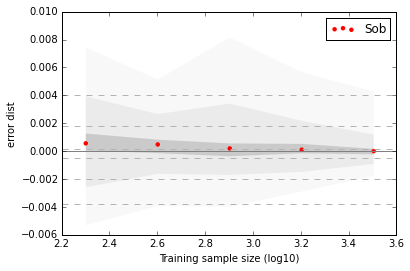

In [93]:
SequenceFunctionStrings = ['Sobol']

import matplotlib
%matplotlib inline

fig, ax = plt.subplots()
x = np.log10(size_sample)

    
for i in range(len(SequenceFunctionStrings)):
    sfs = SequenceFunctionStrings[i]
    color = ['r', 'g', 'b','purple'][i]
    label = ['Sob', 'RHal', 'Has'][i]
    y_90 = sq_err[get_columns(sq_err, sfs)].quantile(.9).values
    y_10 = sq_err[get_columns(sq_err, sfs)].quantile(.1).values
    y_25 = sq_err[get_columns(sq_err, sfs)].quantile(.25).values
    y_75 = sq_err[get_columns(sq_err, sfs)].quantile(.75).values
    y_45 = sq_err[get_columns(sq_err, sfs)].quantile(.45).values
    y_55 = sq_err[get_columns(sq_err, sfs)].quantile(.55).values
    y = sq_err[get_columns(sq_err, sfs)].quantile().values
    ax.fill_between(x, y_10, y_90, color = 'gray', alpha = .05, edgecolor = 'None')
    ax.fill_between(x, y_25, y_75, color = 'gray', alpha = .1, edgecolor = 'None')
    ax.fill_between(x, y_45, y_55, color = 'gray', alpha = .3, edgecolor = 'None')
    ax.scatter(x, y, edgecolor = 'None', color = color, label = label)
    
    #ABM vs itself result:
    test_set['mean_output'] = test_set.iloc[:, 7:].mean(axis = 1)
    ABM_vs_itself_error = test_set.iloc[:, 7:-1].subtract(test_set['mean_output'], axis = 0).as_matrix().flatten()
#     
    for p in [10, 25, 45, 55, 75, 90]:
        ax.axhline(np.percentile(ABM_vs_itself_error,p), 0, 3200, c = '.7', linestyle = '--')

ax.set_ylabel('error dist')
ax.set_xlabel('Training sample size (log10)')
# ax.set_ylim(-.0002, .0012)
# ax.set_xlim(190, 3300)
# ax.set_xscale('log')
ax.axhline(0, color='gray')
ax.legend()
plt.show()

In [12]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import openturns as ot
from joblib import Parallel, delayed
from tqdm import tqdm
import numpy as np

# load ABM file
import islands

def build_Xy_table(ABM, size_sample, size_MC, SequenceFunction, SequenceFunctionString, as_df = True, to_file = True, **kwargs):
    
    import os
    
    problem_ABM = ABM.problem()

    if SequenceFunction == ot.MonteCarloExperiment:
        unscaled_set_X = np.array([ot.MonteCarloExperiment(ot.Uniform(0, 1), size_sample).generate() for i in range(problem_ABM['num_vars'])])
        unscaled_set_X = unscaled_set_X.reshape(size_sample, problem_ABM['num_vars'])
    
    else:
        SequenceFunction = SequenceFunction(problem_ABM['num_vars'], **kwargs)
        unscaled_set_X = np.array(SequenceFunction.generate(size_sample))

    set_X = rescale_sample(unscaled_set_X, problem_ABM['bounds'])
    
    # Evaluate
    set_y = np.array([[ABM.model(p) for p in set_X] for i in range(size_MC)])
    
    # as DataFrame
    df = pd.DataFrame(set_X, columns = problem_ABM['names']).join(pd.DataFrame(set_y).T.add_prefix('evaluation_'))
    
    if to_file:
        # save file
        directory = 'ABM_eval_'+problem_ABM['abm_name']
        filename = SequenceFunctionString+'_ss'+str(size_sample)+'_MC'+str(size_MC)
        if not os.path.exists(directory):
            os.makedirs(directory+'/'+filename)
        df.to_csv(filename, index = False)
        print 'Saved file '+filename
    if as_df:
        return df
    
def rescale_sample(sample, bounds):
    d = [b[1] - b[0] for b in bounds]
    m = [min(b) for b in bounds]
    rescaled_sample = m + (d * sample)
    return rescaled_sample

NEW5


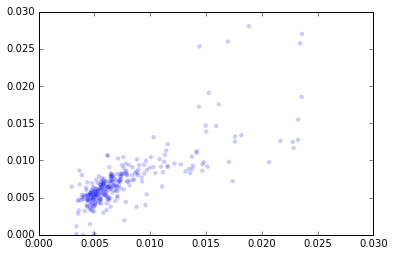

In [9]:
%matplotlib inline

train_set = pd.read_csv('Sobol__ss3200_MC50')
train_set = train_set.replace([np.inf, -np.inf], np.nan).dropna()
train_set.rename(columns = {'rho':'f0','alpha': 'f1','phi': 'f2','pi': 'f3','eps': 'f4','N': 'f5','lambda': 'f6'}, inplace=True)

test_set = pd.read_csv('MC_ss300_MC50')
test_set_X, test_set_Y = test_set.iloc[:, :7], test_set.iloc[:, 7:].mean(axis = 1)

surrogate = train_surrogate(train_set, ABM, XGB = True)

predicted_Y = surrogate.predict(test_set_X.as_matrix())
plt.scatter(predicted_Y, test_set_Y.values, edgecolors = 'None', alpha = 0.2)
plt.xlim(0, 0.03)
plt.ylim(0, 0.03)
plt.title('')
plt.show()